# Exam Preparation: Cox-Ingersoll-Ross

## Setup

In [1]:
import numpy as np
from scipy.stats import norm, ncx2, gamma
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Global settings for LaTeX rendering
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'

# local
import fixed_income_derivatives as fid

## Plotting ZCB Prices, Spot and Forward Rates

We use the information provided in the text to assign values to the parameter: 

In [2]:
# Cox-Ingersoll-Ross model parameters
r0 = 0.032 # initial interest rate
a = 1.2 # rate of reversion
b = 0.048 # parameter to be used for long run mean
sigma = 0.1 # volatility parameter scaling the diffusion term

# compute array of time to maturities for T={0.0,0.5,...,10}
T_max = 10 
alpha = 0.5
M = int(T_max/alpha)+1
T = np.array([i*alpha for i in range(M)])

Using that Vasicek possess an Affine term structure:

In [5]:
p = fid.zcb_price_cir(r0,a,b,sigma,T)
R = fid.spot_rate_cir(r0,a,b,sigma,T)
f = fid.forward_rate_cir(r0,a,b,sigma,T)
#f_6m = fid.zcb_to_forward_rates(T,p,horizon=1) # 6M since we have semiannual data

Make a plot:

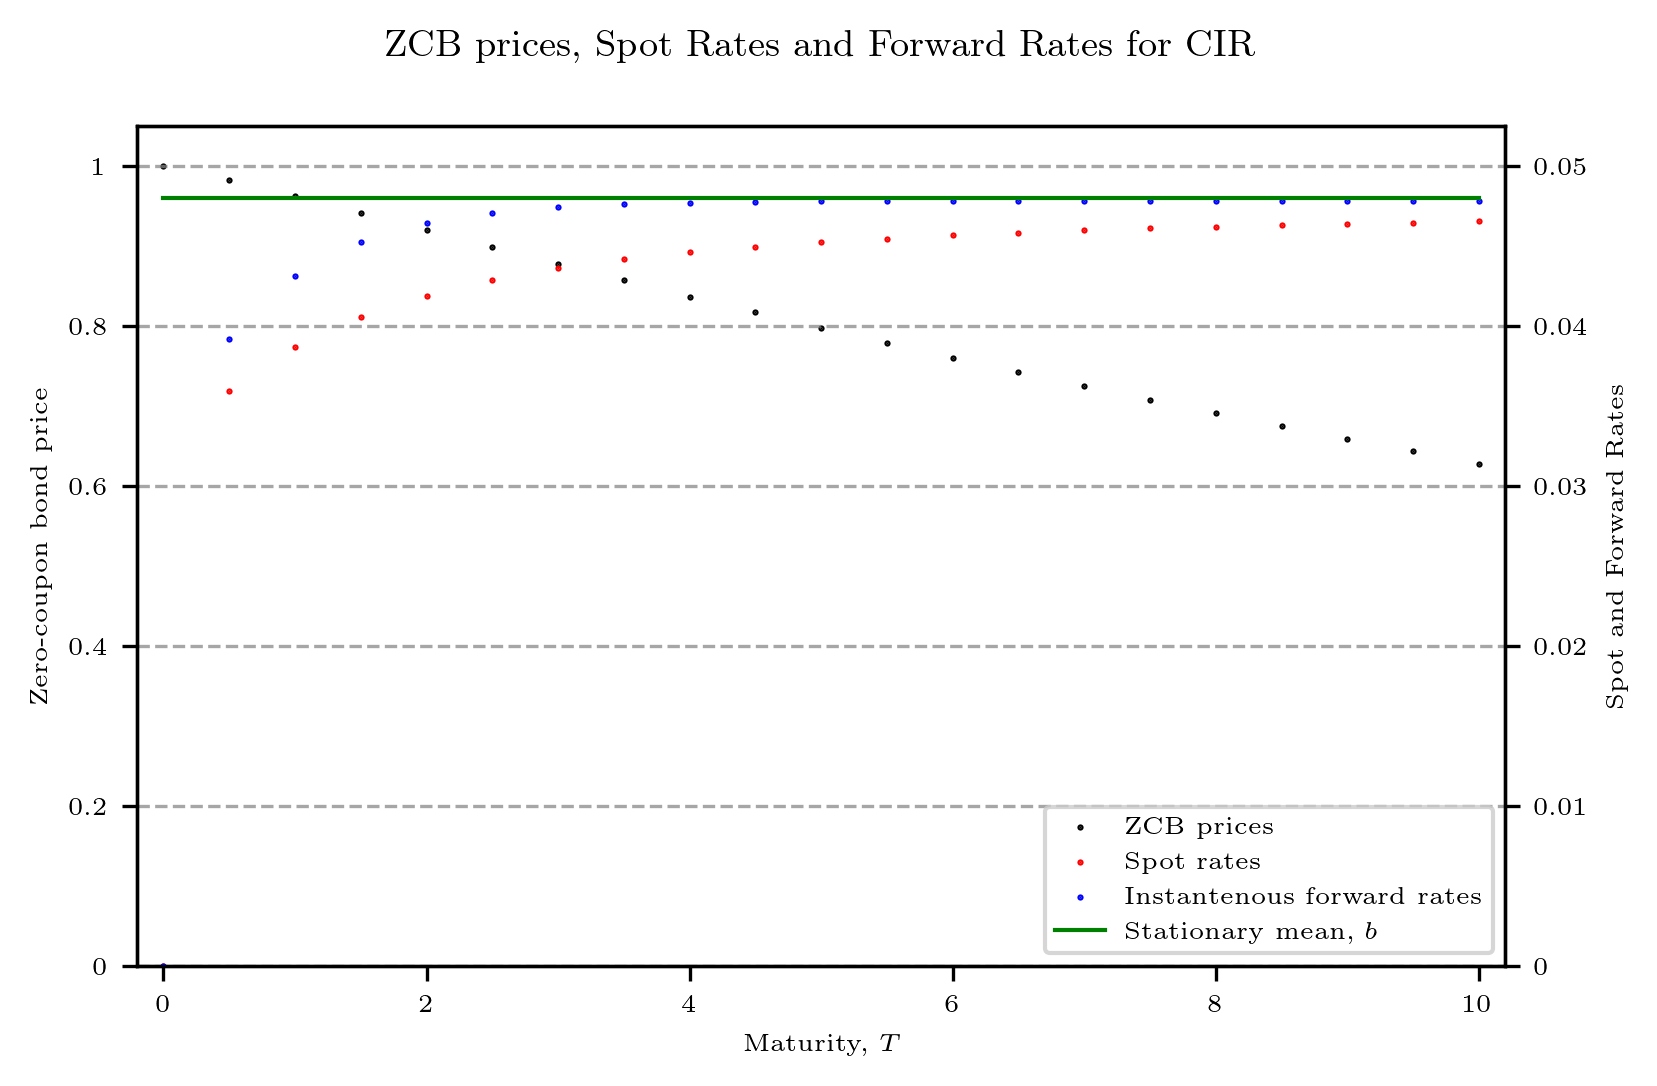

In [7]:
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (6,4))   #
fig.suptitle(f"ZCB prices, Spot Rates and Forward Rates for CIR", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
#
xticks = [0,2,4,6,8,10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity, $T$",fontsize = 6)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1],fontsize = 6)
ax.set_ylim([0,1.05])
ax.set_ylabel(f"Zero-coupon bond price",fontsize = 6)
ax.grid(axis='y', linestyle='--', color='grey', alpha=0.7)

p1 = ax.scatter(T, p, s = 1, color = 'black', marker = ".",label="ZCB prices")

## add second y-axis for the rates
ax1 = ax.twinx()
ax1.set_ylabel(f"Spot and Forward Rates",fontsize = 6)
ax1.set_yticks([0,0.01,0.02,0.03,0.04,0.05,0.06])
ax1.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05,0.06],fontsize = 6)
ax1.set_ylim([0,0.0525])
p2 = ax1.scatter(T, R, s = 1, color = 'red', marker = ".",label="Spot rates")
p3 = ax1.scatter(T, f, s = 1, color = 'blue', marker = ".",label="Instantenous forward rates")
p4 = ax1.plot(T, b*np.ones([M]), color = 'green', marker = "", linewidth = 1, linestyle = "solid",label = "Stationary mean, $b$")


plots = [p1,p2,p3,p4[0]]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 6)
plt.show()

* ZCB prices decay
* Term structure of spot rates is upward sloping 
* Current rate of spot rate is below the stationary mean.
* Term structure of Forward rates is typically a bit further ahead.

## Fitting the Model

**Fitting, not knowing $\sigma$**

In [13]:
# set initial parameters (guess)
param_0 = 0.03, 0.5, 0.04, 0.08

# run optimizer
result = minimize(fid.fit_cir_obj, param_0, args=(R,T),method='Nelder-Mead',options={'xatol': 1e-20, 'disp': True})

# store results
r0_hat, a_hat, b_hat, sigma_hat, fct_value = result.x[0], result.x[1], result.x[2], result.x[3], result.x

# print results
print(f"The fitted parameter values are: r0_hat: {r0_hat:.6f}, a_hat: {a_hat:.6f}, b_hat: {b_hat:.6f}, sigma_hat: {sigma_hat:.6f}")
print(f'SSE of the fit {result.fun:.12f}') # not surprisingly, it depends on xatol!

The fitted parameter values are: r0_hat: 0.032005, a_hat: 1.208735, b_hat: 0.047859, sigma_hat: -0.039171
SSE of the fit 0.000000000001


/var/folders/3j/22yv_sj10t96slp1b8b6z1zw0000gn/T/ipykernel_69509/1489165288.py:5: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(fid.fit_cir_obj, param_0, args=(R,T), method='Nelder-Mead', options={'xatol': 1e-20, 'disp': True})


Fitting the CIR model to spot rates with the objective of recovering all four parameters, we discover that $\sigma$ is difficult to recover implying that $\sigma$ is not well-specified in this model. Despite our inability to recover $\sigma$, we are nonetheless able to recover the remaining parameters $r_0, a$ and $b$ quite well.

**Fitting, knowing $\sigma$**

We do not recover sigma well. So suppose instead we know that sigma is some value. So we remove sigma from param and just put it as an input like "R" and "T".

In [25]:
# set initial parameters (guess)
param_0 = 0.03, 0.5, 0.04 # no sigma!

# run optimizer
result = minimize(fid.fit_cir_no_sigma_obj,param_0,method= "nelder-mead", args=(sigma,R,T), options={'xatol': 1e-20, 'disp': True})
# store results
r0_hat, a_hat, b_hat, fct_value = result.x[0], result.x[1], result.x[2], result.x

# print results
print(f"The fitted parameter values are: r0_hat: {r0_hat:.6f}, a_hat: {a_hat:.6f}, b_hat: {b_hat:.6f}")
print(f'SSE of the fit {result.fun:.12f}') # not surprisingly, it depends on xatol!

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 234
         Function evaluations: 458
The fitted parameter values are: r0_hat: 0.032000, a_hat: 1.200000, b_hat: 0.048000
SSE of the fit 0.000000000000


If we fit the CIR model to spot rates assuming that $\sigma=0.02$ is known the algorithm will converge very fast and the remaining parameters be returned with high accuracy illustrating once again that $r_0, a$ and $b$ are very will identified in the model

## Simulating

Now we will simulate short rates in the CIR model using the usual first order Euler scheme on a grid of mesh $\delta$ that runs from initial time $t_0=0$ to terminal time $T=10$. Denote by $M$, the number of steps in your simulation. The time points in your simulation will be numbered $m=0,1,2, \ldots, M-1, M$ and the time points will be $\left[t_0, t_1, \ldots, t_{M-1}, t_M\right]=[0, \delta, 2 \delta, \ldots, T-\delta, T]$ and $\delta=\frac{T}{M}$. The scheme you will need to implement is a simple Euler first-order scheme of the form
$$
r_m=r_{m-1}+a\left(b-r_{m-1}\right) \delta+\sigma \sqrt{r_{m-1}} \sqrt{\delta} Z_m, \quad m=1,2, \ldots, M
$$
where $Z_m \sim N(0,1), m=1, \ldots, M$ and all the standard normal random variables are independent.

### Simulating One Trajectory

In [35]:
np.random.seed(13)
M_simul, T_simul = 1_000, 10 # time steps, maturity
size_ci = 0.95 # confidence interval
r_simul = fid.short_rate_simul(r0,(a,b,sigma),M_simul,T_simul,method = "cir")
t_simul = np.array([i*(T_simul/M_simul) for i in range(0,M_simul+1)])

# confidence bounds
alpha = (2*a*b)/(sigma**2)
beta = sigma**2/(2*a)
lb, ub = fid.ci_cir(r0,a,b,sigma,t_simul,size_ci)
lb_sd, ub_sd = fid.ci_cir(r0,a,b,sigma,100,size_ci)

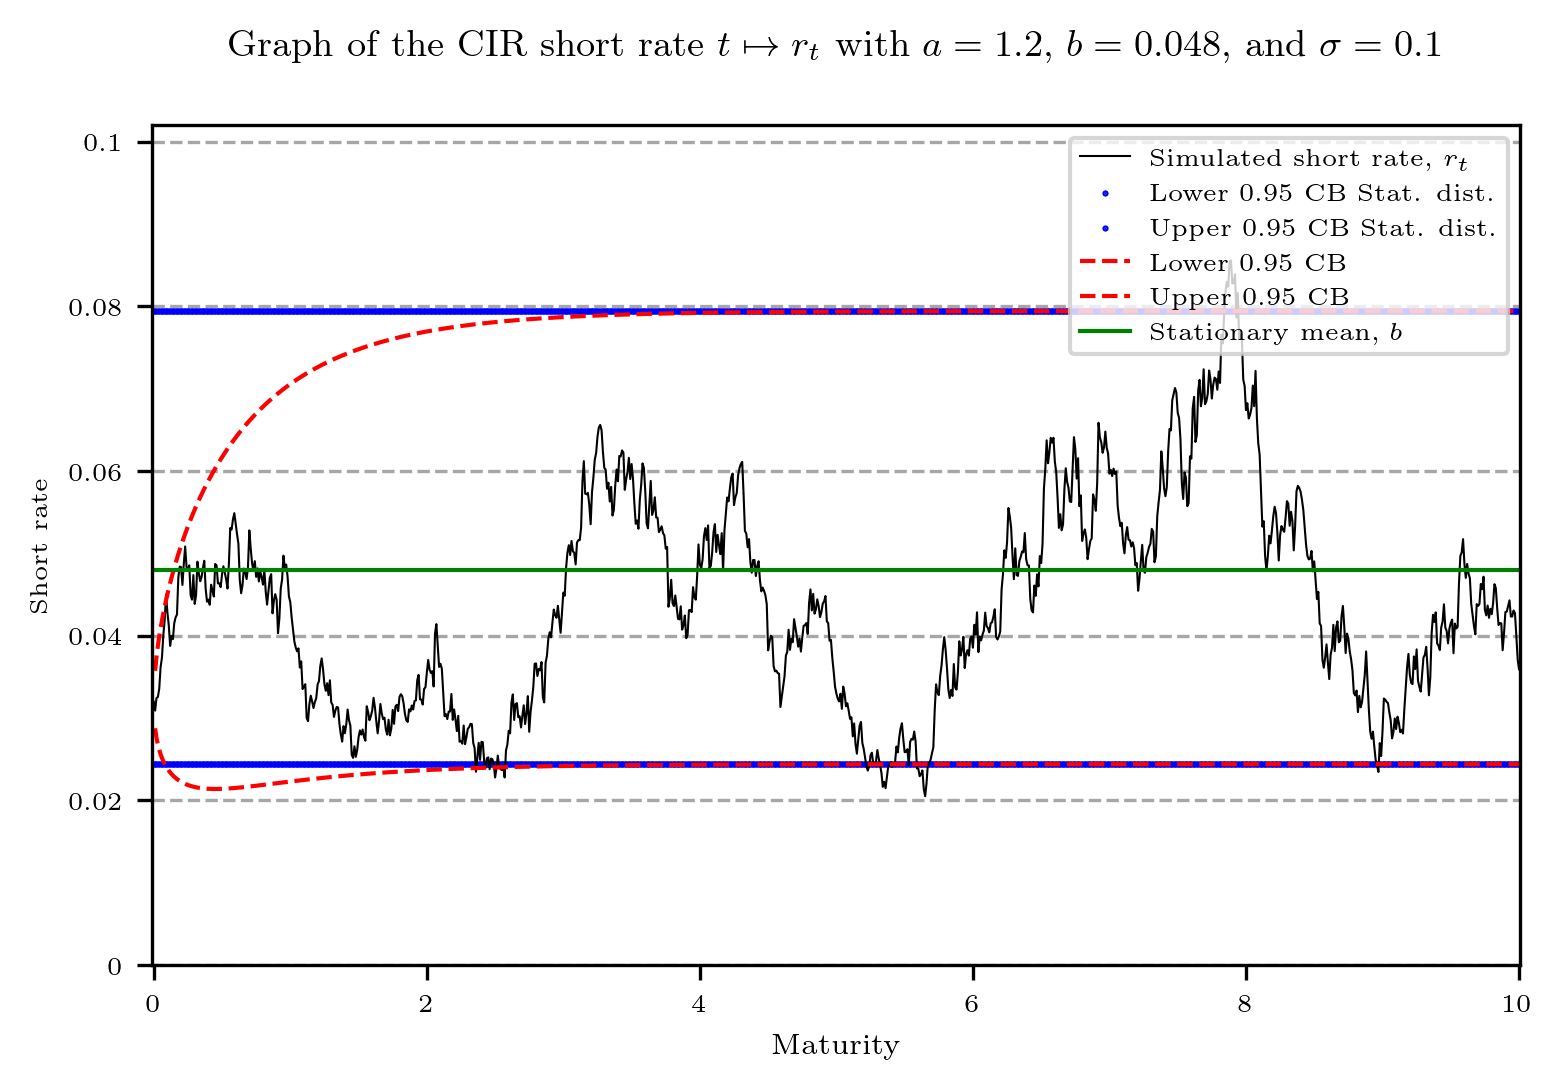

In [54]:
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (6,4))   #
fig.suptitle(f"Graph of the CIR short rate $t \mapsto r_t$ with $a={a}$, $b={b}$, and $\sigma={sigma}$", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
ax.grid(axis='y', linestyle='--', color='grey', alpha=0.7)

xticks = [0,2,4,6,8,10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.01,xticks[-1]+0.01])
plt.xlabel(f"Maturity",fontsize = 7)
yticks1 = [0,0.02,0.04,0.06,0.08,0.1]
ax.set_yticks(yticks1)
ax.set_yticklabels(yticks1,fontsize = 6)
ax.set_ylim([yticks1[0],yticks1[-1] + (yticks1[-1]-yticks1[0])*0.02])
ax.set_ylabel(f"Short rate",fontsize = 6)

# simulated short rate
ax.plot(t_simul, r_simul, color = 'black', marker = "",linewidth = 0.5, label = "Simulated short rate, $r_t$")

# stationary CI
ax.scatter(t_simul, lb_sd*np.ones([M_simul+1]), s = 1, color = 'blue', marker = ".",label=f"Lower {size_ci} CB Stat. dist.")
ax.scatter(t_simul, ub_sd*np.ones([M_simul+1]), s = 1, color = 'blue', marker = ".",label=f"Upper {size_ci} CB Stat. dist.")

# Simulated CI
ax.plot(t_simul, lb,  linewidth = 1,color = 'red', linestyle = "dashed",label=f"Lower {size_ci} CB")
ax.plot(t_simul, ub, linewidth = 1, color = 'red', linestyle = "dashed",label=f"Upper {size_ci} CB")

# stationary mean
ax.plot(t_simul, b*np.ones([M_simul+1]), color = 'green', marker = "", linewidth = 1, linestyle = "solid",label = "Stationary mean, $b$")


ax.legend(loc = "upper right",fontsize = 6)
plt.show()

* Confidencen bounds should narrow as it comes closer to the bounds of the statioanry distribution.

The value $r_3$ in the simulation is the short three years after the initial point, and since the confidence interval of $r_3$ is close to that of the stationary distribution, we can conclude that after 3 years the short rate has most likely almost settled to its stationary distribution. Convergence to the stationary distribution will be faster if either $a$ is large or $\sigma$ is small.

## Swap Rates

We consider interest rate swaps that involve swapping $6 \mathrm{M}$ floating rate payments (EURIBOR say) paid semiannually for fixed payments also paid semi-annually. 
- present time is $t=0$ 
- $6 \mathrm{M}$ floating rate to be paid at time $T=0.5$ has just been announced. 
- notional of these swaps is just 1.

We know the first half-year, so we don't have to take into account that some time of the initial libor rate has already past.
$$
R_{\text {swap }}(t=0)=\frac{P(0,0)-p(0, N)}{S_{\text {swap }}}
$$

Where the denominator is the accrual factor which comes from the fixed leg: $\sum_{i=1}^N \alpha_i p\left(t, T_i\right)$ where $\alpha$ is tenor. The floating leg was simply since we could compute it as a telescoping sum.

Computing par swap rate (**remember to rerun begin of code**)

In [56]:
# 10Y swap pricector
idx_n, idx_N = 0, 20 # first and last fixing where 20/2 = 10Y
S_swap = fid.zcb_to_accrual_factor(T[idx_n],T[idx_N],'semiannual',T,p)
R_swap = fid.zcb_to_par_swap_rate(T[idx_n],T[idx_N],'semiannual',T,p)
print(f'R_swap is {R_swap}')

R_swap is 0.04680067874809556


**Alternatively**

In [55]:
# 10 Y swap price
#idx_n, idx_N = 0, 20 # first and last fixing where 20/2 = 10Y
#S_swap = 0 
#for idx in range(idx_n+1,idx_N+1): # already added 1 to M, hence no need for M+1 here, so M is included!
#    S_swap += 0.5*p[idx]

#R_swap = (p[idx_n]-p[idx_N])/S_swap
#print(f'R_swap is {R_swap}')

**New we have to do it for all maturities and not just for 10Y**

In [57]:
# Plotting the spot par swap rate
def swap_fct(idx_n,idx_N,alpha,p):
    S_swap = 0
    for idx in range(idx_n+1,idx_N+1):
        S_swap += alpha*p[idx]
    R_swap = (p[idx_n] - p[idx_N])/S_swap
    return R_swap, S_swap

R_swap_plot = np.zeros([M])
S_swap_plot = np.zeros([M])
idx_N_plot = np.array([i for i in range(1,M)])
for idx in idx_N_plot:
    R_swap_plot[idx], S_swap_plot[idx] = swap_fct(0,idx,alpha,p)[0], swap_fct(0,idx,alpha,p)[1]

Duration can be understood as the average time it takes to receive the cash flows from an investment, thus directly linking it to the maturity of the investment. The longer the maturity
- the longer it typically takes to recoup the initial investment. 
- This concept is particularly evident in the case of a zero-coupon bond (ZCB), where the duration is exactly equal to its maturity, as all cash flows occur at maturity. 
- In our case, for maturity 10Y bond the S_Swap (accrual factor which is approx duration) is 8.11 years!

**Adding 6M Forward Rates**

In [58]:
f_6m = fid.zcb_to_forward_rates(T,p,horizon = 1) # 6M for semiannual means 1 in horizon
f_6m

array([0.        , 0.03595898, 0.04135213, 0.04429405, 0.04590023,
       0.04677756, 0.0472569 , 0.04751883, 0.04766197, 0.0477402 ,
       0.04778295, 0.04780632, 0.04781909, 0.04782607, 0.04782988,
       0.04783197, 0.04783311, 0.04783373, 0.04783407, 0.04783426,
       0.04783436])

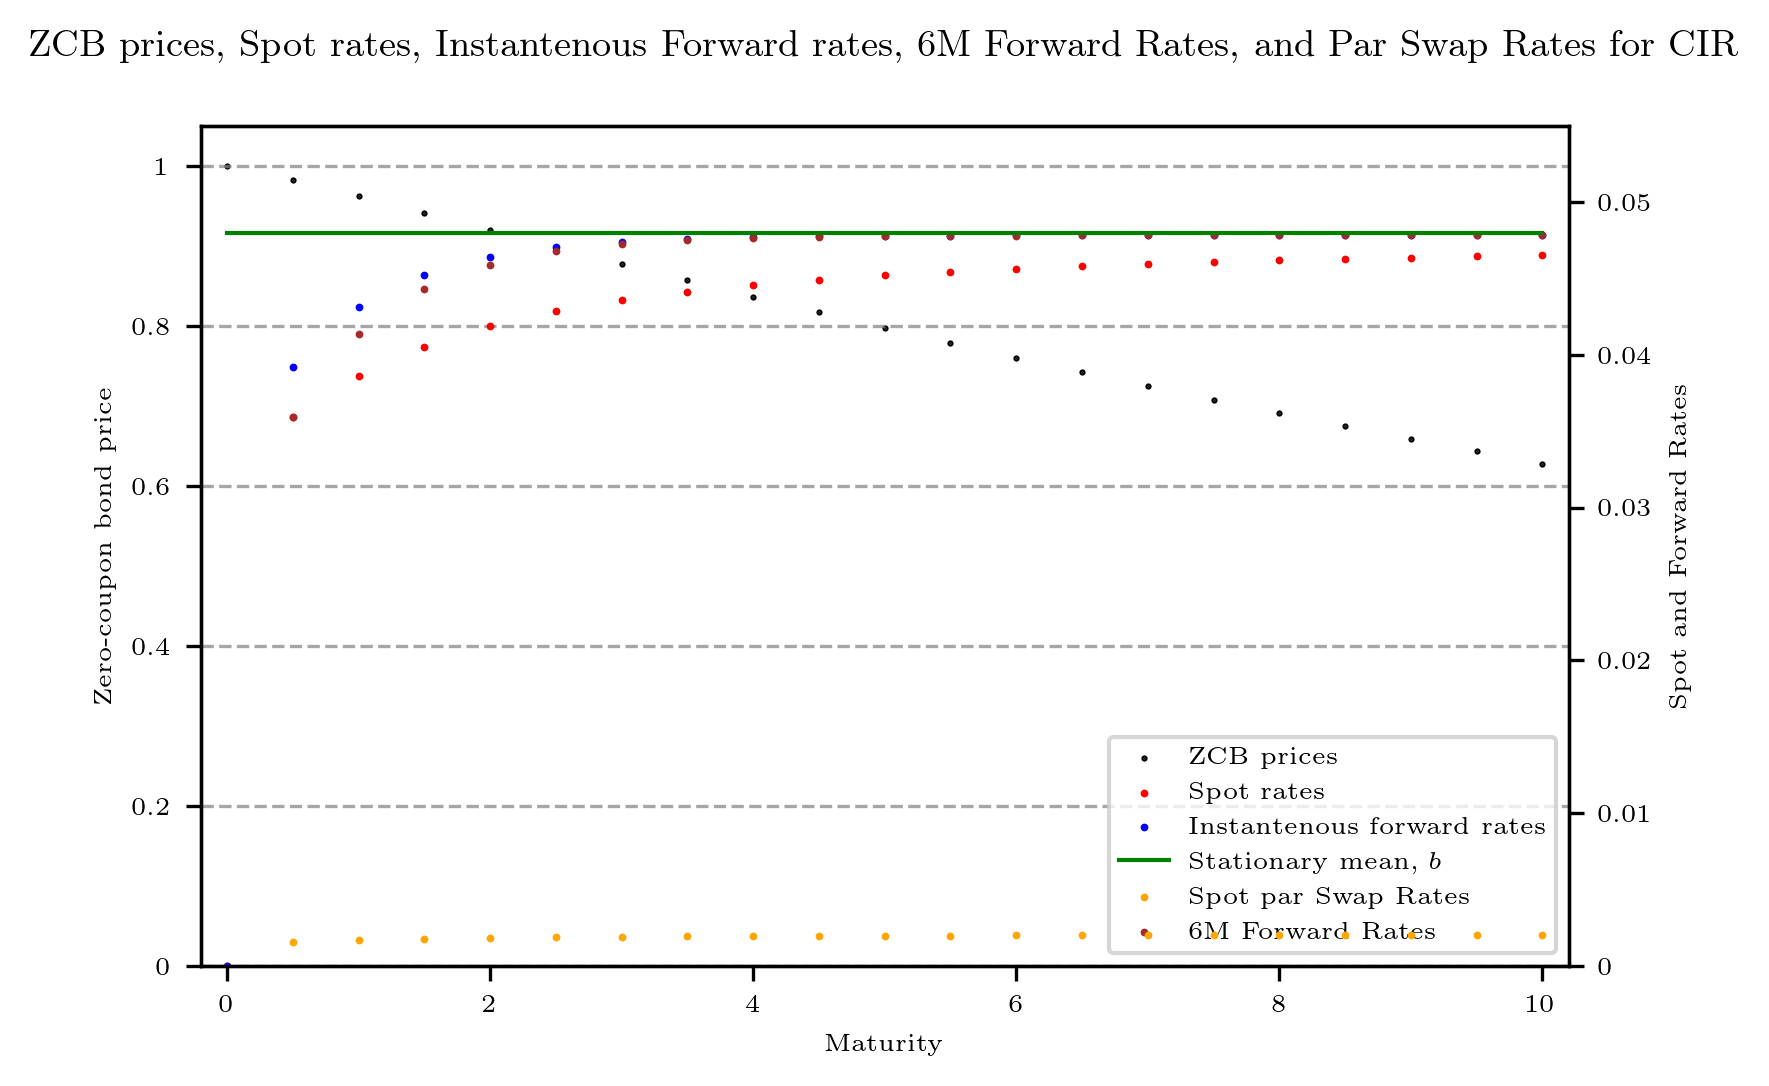

In [63]:
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (6,4))   #
fig.suptitle(f"ZCB prices, Spot rates, Instantenous Forward rates, 6M Forward Rates, and Par Swap Rates for CIR", fontsize = 9)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
#
xticks = [0,2,4,6,8,10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1],fontsize = 6)
ax.set_ylim([0,1.05])
ax.set_ylabel(f"Zero-coupon bond price",fontsize = 6)
ax.grid(axis='y', linestyle='--', color='grey', alpha=0.7)

p1 = ax.scatter(T, p, s = 1, color = 'black', marker = ".",label="ZCB prices")

## add second y-axis for the rates
ax1 = ax.twinx()
ax1.set_ylabel(f"Spot and Forward Rates",fontsize = 6)
ax1.set_yticks([0,0.01,0.02,0.03,0.04,0.05,0.06])
ax1.set_yticklabels([0,0.01,0.02,0.03,0.04,0.05,0.06],fontsize = 6)
ax1.set_ylim([0,0.055])
p2 = ax1.scatter(T, R, s = 3, color = 'red', marker = ".",label="Spot rates")
p3 = ax1.scatter(T, f, s = 3, color = 'blue', marker = ".",label="Instantenous forward rates")
p4 = ax1.plot(T, b*np.ones([M]), color = 'green', marker = "", linewidth = 1, linestyle = "solid",label = "Stationary mean, $b$")
p5 = ax1.scatter(T[1:], R_swap_plot[1:], s = 3, color = 'orange', marker = ".",label="Spot par Swap Rates")
p6 = ax1.scatter(T[1:], f_6m[1:], s = 3, color = 'brown', marker = ".",label="6M Forward Rates")

plots = [p1,p2,p3,p4[0],p5,p6]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 6)
plt.show()

* We see that the par swap rates and ZCB spot rates are almost the same. 
    - The net cahs flow (fix - float) for payer swap is quite small, so the net payment until the end is relative small. 
    - Likewise, for ZCB the payment is at the very end. 
* Remember the accrual factor of a swap is change in value of swap if par-swap rate changes by 1 bp, essentially sensitive of bond price to changes in par-swap rate. Likewise, for a regular duration is the change in value of a bond for a unit change in YTM. So you can say that accrual factor plays same role as duration for ZCB. Notice, duration of ZCB is equal to maturity.
* Alternatively, we can interpret duration as average time until you get your cash flow back, hence larger maturity the longer it takes to get investment back.Duration is a measure of when that happens. Hence why equal to maturity to ZCB. Hence duration of a bond is proportional to maturity. In our case, for maturity 10 Y bond the S_Swap (accrual factor which is approx duration) is 8.11 years!
* Par swap rates are a weighted average of the $6 \mathrm{M}$ forward rates with more weight placed on forward rates over the near future.
* Par swap rates and zero coupon bond rates are relatively close because an interest rate swap is in nature quite close to a zero coupon bond. Now, a zero coupon bond band pays no coupons and has only one cashflow at the very end. The net coupons to an interest rate swap are however are also relatively small as they consist of the difference between the fixed par swap rate and the floating rate in this case 6M EURIBOR. Furthermore, since the fixed par swap rate is a weighted average of $6 \mathrm{M}$ forward rates, the average net coupon to an interest rate swap tends to be close to 0 .

## Interest Rate Cap

- Consider the pricing of an interest rate cap on future EURIBOR fixings that begins immediately and ends in T = 5 years. 
- The cap will have a strike of R=0.045.
- We will price this derivative using simulation.

An interest rate caplet caps, for a cost, the interest payment on a single floating rate payment. An interest rate cap caps a series of floating rate payments. An interest rate cap can thus be seen as the sum of a series of caplets and the price of a cap can therefore be computed as the sum of the prices of the caplets making up the interest rate cap. A caplet can be seen as a European call option with a specific future LIBOR rate fixing as the underlying asset or equivalently as a European put option on the ZCB price $p\left(T_{i-1}, T_i\right)$ realized at $T_{i-1}$, the time of a the LIBOR rate announcement, for 1 unit of currency delivered at the time $T_i$ of payment of the LIBOR rate.

**i) Deduce an expression for the discounted payoff of a caplet at time $t=0$ on the underlying reference rate $L\left(T_{i-1}, T_i\right)$.**

Assume that we have simulated the short rate from time $t=0$ to time $T_i$ using $M$ steps and denote the realized values of the short rate by $r_0, r_1, \ldots, r_{M-1}$. The payoff of at caplet with strike $R$ and underlying asset $L\left(T_{i-1}, T_i\right)$ discounted back to time $t=0$, denoted $\tilde{\chi}_i$, is then
$$
\tilde{\chi}_i=\exp \left\{-\frac{T}{M} \sum_{m=0}^{M-1} r_m\right\} \cdot\left[1+\left(T_i-T_{i-1}\right) R\right]\left(\frac{1}{1+\left(T_i-T_{i-1}\right) R}-p\left(T_{i-1}, T_i\right)\right)_{+}
$$

**ii) Simulate at least $N=1,000$ trajectories for the short rate up to time $T=5$ and in each simulation, at least $M=1,000$ steps should be taken. 
For each simulated path, compute the discounted payoffs to all caplets with a maturity less than 5 years. Once you have simulated $N$ trajectories, you can compute the price of the caplets by averaging the discounted payoffs.**

We compute price of 5Y interest rate cap in the CIR model:

In [67]:
# setup 
T_cap_begin, T_cap_end = 0.5, 5
strike = 0.045
idx_cap_begin, idx_cap_end = int(T_cap_begin/alpha), int(T_cap_end/alpha)
price_caplet = np.zeros([idx_cap_end+1])
M_simul_cap, N_simul = 5_000, 20_000
chi = np.zeros([idx_cap_end-1,N_simul])
r_simul_cap = np.zeros([M_simul_cap+1])

for i in range(0,N_simul):
    r_simul_cap = fid.short_rate_simul(r0,(a,b,sigma),M_simul_cap,T_cap_end,method = "cir")
    for idx in range(idx_cap_begin,idx_cap_end):
        idx_r_announcement = idx*int((alpha*M_simul_cap)/T_cap_end)
        idx_payment = (idx+1)*int((alpha*M_simul_cap)/T_cap_end)
        p_cap = fid.zcb_price_cir(r_simul_cap[idx_r_announcement],a,b,sigma,alpha)
        chi[idx-1,i] = np.exp(-sum(r_simul_cap[0:idx_payment+1])/idx_payment)*(1+alpha*strike)*max(1/(1+alpha*strike)-p_cap,0)

for idx in range(idx_cap_begin+1,idx_cap_end+1):
    price_caplet[idx] = sum(chi[idx-2,:])/N_simul
print(f"Caplet prices: {price_caplet*10_000},Cap price: {sum(price_caplet)}")

Caplet prices: [ 0.          0.          8.84448543 17.19600969 21.98389802 24.74252474
 25.96422594 27.15363014 27.81204342 27.91755675 28.10200736],Cap price: 0.020971638148291723


The lower the strike the higher the price of the interest rate cap. Since an interest cap is a sum of caplets each of which are simply European options, the price of the cap is increasing in σ.

## Payer Swaption

Also compute the price of a $2 \mathrm{Y} 3 \mathrm{Y}$ payer swaption with a strike of $K=0.045$ by using a similar approach of computing discounted payoffs for each trajectory and averaging over all simulations.

In this case, the discounted payoff becomes
$$
\tilde{\chi}=\exp \left\{-\frac{T}{M} \sum_{m=0}^{M-1} r_m\right\} \cdot S_{s w a p}\left(R_{s w a p}-K\right)_{+}
$$


In [71]:
# Computing the price of a 2Y3Y swaption
# setup
idx_n_swaption, idx_N_swaption = 4, 10
M_simul_swaption, N_simul, T_simul_swaption = 2_000, 20_000, T[idx_n_swaption]
chi, price_swaption_simul = np.zeros([N_simul]), np.zeros([N_simul])
T_swaption = np.array([T[i] - T[idx_n_swaption] for i in range(idx_n_swaption,idx_N_swaption+1)])
R_swaption = 0.045

for i in range(0,N_simul):
    r_simul_swaption = fid.short_rate_simul(r0,(a,b,sigma),M_simul_swaption,T_simul_swaption,method = "cir")
    p_swaption = fid.zcb_price_cir(r_simul_swaption[-1],a,b,sigma,T_swaption)
    R_swap, S_swap = swap_fct(0,idx_N_swaption-idx_n_swaption,alpha,p_swaption)
    chi[i] = max(R_swap-R_swaption,0)*S_swap
    price_swaption_simul[i] = np.exp(-(T_simul_swaption/M_simul_swaption)*sum(r_simul_swaption))*chi[i]
price_swaption = sum(price_swaption_simul)/N_simul
print(f"price_swaption: {10_000*price_swaption}")

price_swaption: 85.8330623801571


Here, $M=2,000$ is the number of steps in the simulation up to time $T=2, S_{s w a p}$ is the accrual factor of the underlying $3 \mathrm{Y}$ swap in $T=2$ years when the swaption expires and $R_{s w a p}$ is the par swap rate of the then $3 \mathrm{Y}$ swap. As mentioned above, the simulation was repeated $N=20,000$ times and we get that the price of the swaption becomes $85.70 \mathrm{bps}$.